In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgb
from scipy.stats import chisquare
from util import resolve_path

In [2]:
FILEPATH_VITALS = 'H:/Documents/NCATS/GBM/clinicalData/Updated_All_Vital_Sign_Data_for_Glioblastoma_Subjects_sent_to_Zhu_1-18-2023.xlsx - All_Vital_Data.csv'

In [3]:
def preprocess_demo_df(filepath: str=FILEPATH_VITALS) -> pd.DataFrame:
    '''Does not exit pipe. Does not modify structure (e.g. `set_index()`); that's done in `set_index_4_indep_demo_df()`.'''

    # Define available column types
    column_types = {
        # 'Row No': 'Int64',
        'Subject': 'str',
        'Gender': 'category',
        'Race': 'category',
        'Ethnicity': 'string',  # string, not category, because cannot have `np.nan` as a category level (i.e. "nullable")
        'Age at time of Vital': 'Int64',
        'Date': 'str',  # to be parsed
        # 'btris_cluster_id': 'category',
        'btris_cluster_label': 'category',
        # 'Result_Name': 'category',
        'Result_Value_Text': 'str',
        'Result_Value_Numeric': 'float64',
        #'Additional_Note': 'str',  # all blanks
        'Unit_of_Measure': 'str'
    }

    # Select desired columns
    selected_cols = list(column_types.keys())

    # Specify file-wide NA values
    na_values = ['', 'NULL', 'Unknown']

    # Import data
    df = pd.read_csv(filepath, usecols=selected_cols,
                     dtype=column_types, na_values=na_values)

    # Parse datetimes
    date_format = '%m/%d/%y %H:%M'
    df['Date'] = pd.to_datetime(df['Date'], format=date_format)

    # In `Ethnicity` column, fix misspelled and missing values
    replacements = {
        'Not Hispanic or Lati': 'Not Hispanic or Latino',
        'N': None,  # Is 'N' considered a missing value? BTRIS doesn't know, so better be safe
        'Not Reported': None
    }
    df['Ethnicity'] = df['Ethnicity'].replace(replacements)

    # Cast nullable categorical columns into 'category' type, the non-nullable ones having already been cast
    df['Ethnicity'] = df['Ethnicity'].astype('category')

    '''This is for `verify_consistent_demography()` in `multi_type_processing`.'''
    # # Demographic characteristics don't change over time for a given `Subject` (vitals information do, but they are irrelevant here, so we drop them)
    # df.drop_duplicates(subset='Subject').to_pickle(resolve_path('../intermediates/vitals_demo.pkl'))

    print(f'Number of unique patients with recorded vitals:\t{df["Subject"].unique().shape[0]}')

    # Filter rows so that `Subject`s are represented by unique rows
    return df.drop_duplicates(subset='Subject')



In [14]:
def set_index_4_indep_demo_df(df: pd.DataFrame):
    '''Exits pipe because further processing is done elsewhere.'''

    # Select desired columns
    df = df[['Subject', 'Gender', 'Race', 'Ethnicity']]

    # Set index to `Subject` ID, to concatenate with similar DataFrames later
    df = df.set_index('Subject')

    # Serialize the DataFrame
    df.to_pickle('.\\results\\explanatory_demo.pkl')

In [10]:
# df = preprocess_demo_df()

Number of unique patients with recorded vitals:	1151


In [15]:
set_index_4_indep_demo_df(preprocess_demo_df())

Number of unique patients with recorded vitals:	1151


### Set text sizes for the two plots

In [17]:
PLOT_SMALL_SIZE  = 24
PLOT_MEDIUM_SIZE = 32
PLOT_BIGGER_SIZE = 42
plt.rc('font', size=PLOT_SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=PLOT_BIGGER_SIZE)     # fontsize of the axes title
# plt.rc('axes', labelsize=PLOT_MEDIUM_SIZE)    # fontsize of the x and y labels
# plt.rc('xtick', labelsize=PLOT_SMALL_SIZE)    # fontsize of the tick labels
# plt.rc('ytick', labelsize=PLOT_SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=PLOT_MEDIUM_SIZE)    # legend fontsize
# plt.rc('figure', titlesize=PLOT_BIGGER_SIZE)  # fontsize of the figure title

In [22]:
def visualize_demo_piecharts(uniques_df: pd.DataFrame):
    '''Three simple pie charts for each of `['Gender', 'Race', 'Ethnicity']`. Exits pipeline because it's not modifying the data.'''

    # List of columns for which to create pie charts
    plotted_cols = ['Gender', 'Race', 'Ethnicity']

    # Custom color palette with seven colors
    default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    # Create a big figure with subplots
    _, axes = plt.subplots(1, len(plotted_cols),
        figsize=(12 * len(plotted_cols), 14))

    # Iterate each of those columns
    for ax, col, color in zip(axes, plotted_cols, default_colors):
        # Get counts for each level in the current column
        counts = (uniques_df[col].value_counts(dropna=False)
                .reset_index(name='counts'))

        # Labels and values for the pie chart
        labels = counts[col]
        values = counts['counts']
        pcts = values / values.sum() * 100.0

        # Convert wedge color and background color to sRGB ([0,1])
        wedge_rgb = to_rgb(color)
        bg_rgb = to_rgb('white')  # TK why isn't this used/referenced?

        # Calculate the relative luminance of the lighter of the colors (invariably the background color, which is 'white' aka [1,1,1])
        # Source: https://www.w3.org/TR/WCAG20/#relativeluminancedef
        L1 = 0.2126 + 0.7152 + 0.0722

        # Calculate the bold [R, G, B] (of the wedge) used in the relative luminance definition
        # Source: https://www.w3.org/TR/WCAG20/#relativeluminancedef
        wedge_bold_rgb = [(value / 12.92) if value <= 0.03928
                        else ((value + 0.055) / 1.055) ** 2.4
                        for value in wedge_rgb]

        # Calculate the relative luminance of the darker of the colors (the wedge color, which is variable)
        # Source: https://www.w3.org/TR/WCAG20/#relativeluminancedef
        L2 = (0.2126 * wedge_bold_rgb[0] + 0.7152 * wedge_bold_rgb[1]
            + 0.0722 * wedge_bold_rgb[2])

        # Calculate the WCAG2.0-defined contrast ratio ((L1 + 0.05) / (L2 + 0.05))
        # Source: https://www.w3.org/TR/WCAG20/#contrast-ratiodef
        contrast = (L1 + 0.05) / (L2 + 0.05)

        # Choose text color based on contrast ratio
        text_color = 'white' if contrast > 1 else 'black'
        # TK don't know if the text color is correctly chosen

        # Create pie chart on the specified axis
        wedges, _ = ax.pie(values, startangle=50)
        ax.set_title(f'Frequency of Patients by {col}')

        # Add percentage labels at exploded positions for thinner wedges
        for wedge, pct in zip(wedges, pcts):
            # Percentage (label) explosions (explode if less than 5%)
            explosion = 0 if pct > 5.0 else 0.4 * wedge.r
            # Angle at center of wedge
            angle = wedge.theta2 - 0.5 * (wedge.theta2 - wedge.theta1)
            # The arrowhead is invisible but takes up space,
            # so avg(0.5 + 0.4, 1 + 0.25) != 1
            arrow_head = ((0.5 * wedge.r + explosion) * np.cos(np.deg2rad(angle)),
                        (0.5 * wedge.r + explosion) * np.sin(np.deg2rad(angle)))
            # Arrow points in, toward the pie center
            arrow_shaft = ((0.25 * wedge.r) * np.cos(np.deg2rad(angle)),
                        (0.25 * wedge.r) * np.sin(np.deg2rad(angle)))
            # Vector addition
            arrow_tail = tuple(a + b for a, b in zip(arrow_head, arrow_shaft))
            # TK the thin wedge percents still overlap but i don't care
            ax.annotate(f'{pct:.1f}%', xy=arrow_head,
                        xytext=(arrow_head if explosion == 0 else arrow_tail),
                        ha='center', va='center',
                        color=(text_color if explosion == 0 else 'black'),
                        arrowprops=dict(arrowstyle='-', connectionstyle='arc3'))
            # TK make text more aligned with arrow

        # Set the aspect ratio to 'equal' for a circular pie chart
        ax.set_aspect('equal')

        # Create the legend
        legend_labels = [f'{label}: {count} ({f"{pct:.1f}"}%)' for label,
                        count, pct in zip(labels, values, pcts)]
        ax.legend(wedges, legend_labels, loc='lower left')

    # Adjust spacing between subplots
    plt.tight_layout()
    # Save the big figure as a PNG file
    plt.savefig('.\\plots\\demo_info.png')
    # plt.show()

Number of unique patients with recorded vitals:	1151


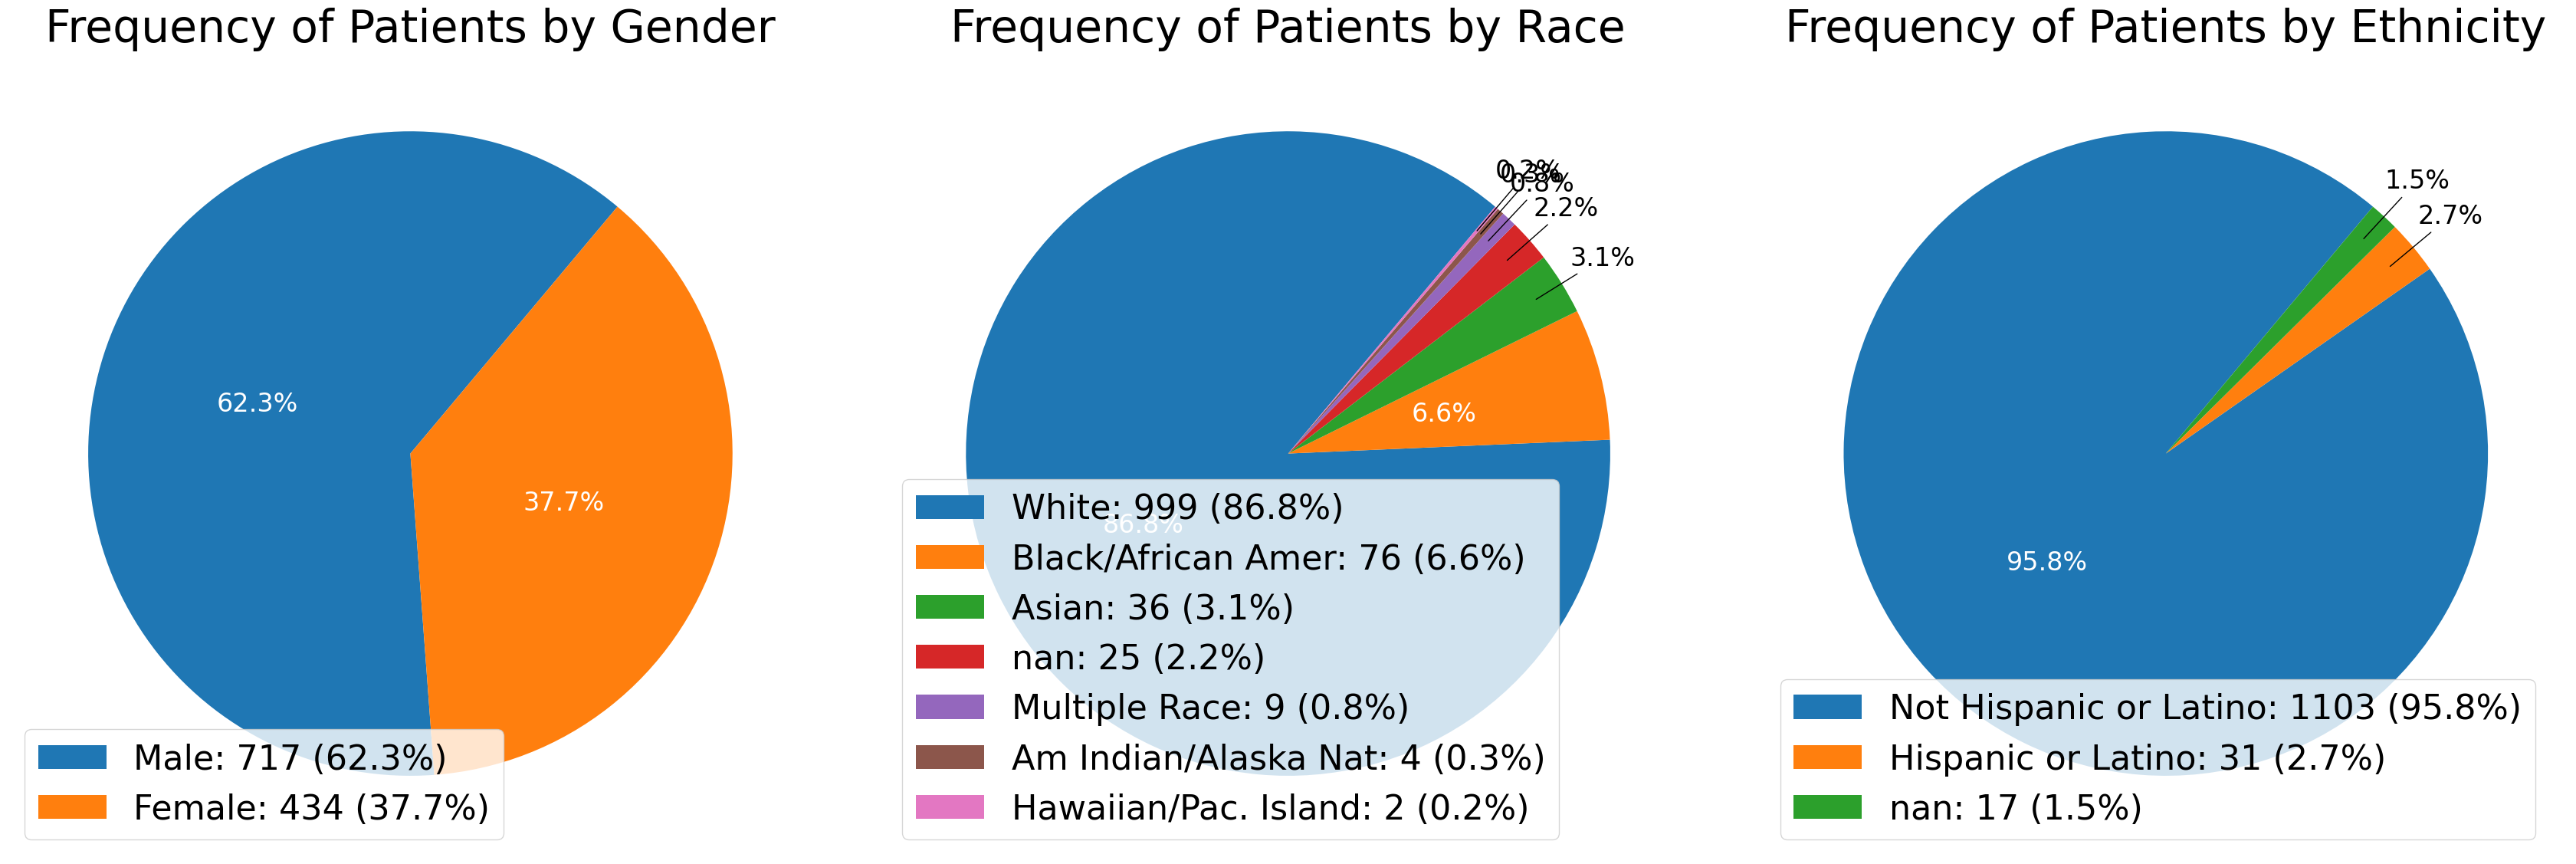

In [23]:
visualize_demo_piecharts(preprocess_demo_df())

In [27]:
def test_chisq_association(df: pd.DataFrame):
    '''Perform chi-square tests for association to analyze whether the demographics of GBM patients differ significantly from the demographics of the US population at large.  The demographic variables in question are three: ['Gender', 'Race', 'Ethnicity'].'''
    '''Purpose: To get an initial understanding of relationships within the data.'''

    '''! Note about Independence: I am going to construct artificially the two "levels" of the dependent variable.  One level ("presence") comes from the GBM data processed above, and the other ("non-presence") comes from the 2020 US Census data.  Importantly, the Census data will contain members who also belong to the GBM data, and so the two levels are not completely independent of each other.  However, i will still proceed with an analysis on the fact that the size (300 million) of the Census data far outweighs that (uniques_df.shape[0] == 1151) of the GBM data, meaning the effect of overlap members in the Census data is negligible.  (Of course, the GBM data is intentionally selected so it is independent of the Census data)'''

    '''! Note about unequal sample sizes: The Census dataset/sample is far larger (300 million) than the GBM dataset/sample (~1000), so a naive chi-square test would be so skewed toward the Census demographic proportions.  Therefore, i will simply scale down the Census sample to the same size as the GBM sample, keeping the original demographic proportions.'''

    '''! Limitations:'''
    '''    a. These results are not adjusted for confounding factors, potential or actual (most importantly time range: GBM data is cumulative across time, while Census data is snapshot);'''
    '''    b. The GBM data source may not be representative of all patients diagnosed with GBM in the general (US) population (GBM data only captures NIH patients);'''
    '''    c. Controlled/multivariate analyses are required for more definitive conclusions (e.g. for those regarding the effect of combinations of gender-race-ethnicity);'''
    '''    d. Since i couldn't find NIH (as opposed to US) general pop. data, definitions of 'Race', 'Ethnicity' could differ between the GBM and general pop. datasets at the data collection level.'''

    '''1. Hypotheses:'''
    '''  a. Null hypotheses: There is no difference in demographic (['Gender', 'Race', 'Ethnicity']) distribution in the GBM group from what would be expected if GBM were independent of demographics in the US general population.'''
    '''  b. Alternative hypotheses: There is such a difference.'''

    '''2. Assumptions:'''
    '''  1. ! Random sampling: The `genpop` frequencies (renamed such below) are from the 2020 US Census and is thus a random sample.  However, the `GBM` frequencies (from our data) are (from what i've been told) pulled from NIH patient records (i.e. records of patients who have gone to NIH), which means it's only a random sample (census) from the population of people who have gone to the NIH as patients, not from the general US population.  So, with respect to the `genpop` frequencies, the `GBM` frequencies are biased (and vice versa).'''
    '''  2. ! Independence of observations:'''
    '''  2.a. Within groups: The records were pulled indiscriminately (w.r.t. ['Gender', 'Race', 'Ethnicity']), so within the GBM data, observations are independent.  Obviously, with the Census data being a census, there is no speak of independence between observations within the group.'''
    '''  2.b. ! Between groups: While the GBM data and the Census data are not perfectly independent, as was explained in the Note about Independence, the Census data is largely independent of the former.'''
    '''  3. Expected cell frequencies: [See below].'''
    '''  4. Large sample sizes: The sample sizes should be large enough.'''

    # The three columns for which chi-square tests will be run
    TEST_COLUMNS = ['Gender', 'Race', 'Ethnicity']

    # Gender
    # Gen. pop. data link: https://www.census.gov/data/tables/2020/demo/age-and-sex/2020-age-sex-composition.html
    # Gen. pop. data name: Age and Sex Composition in the United States: 2020, Table 1. Population by Age and Sex: 2020 [<1.0 MB]
    GENPOP_GENDER_DICT = {'Male': 159461, 'Female': 165807}

    # Race
    # Gen. pop. data link: https://www.census.gov/library/visualizations/interactive/race-and-ethnicity-in-the-united-state-2010-and-2020-census.html
    # Gen. pop. data name: Race and Ethnicity in the United States: 2010 Census and 2020 Census
    # Note that GBM data spans from around 1990 to 2022, and in 2000 the Census began including the option to select more than one race categories, meaning 2000 census race data is not directly comparable to past censal race data, and thus not past self-identified data on race in the GBM dataset. (See: https://web.archive.org/web/20090831085310/http://quickfacts.census.gov/qfd/meta/long_68178.htm)
    GENPOP_RACE_DICT = {'White': 204277273,  # White alone
                        'Black/African Amer': 41104200,  # Black or African American alone
                        'Am Indian/Alaska Nat': 3727135,  # American Indian and Alaska Native alone
                        'Asian': 19886049,  # Asian alone
                        'Hawaiian/Pac. Island': 689966,  # Native Hawaiian and Other Pecific Islander alone
                        np.nan: 27915715,  # Some Other Race alone
                        'Multiple Race': 33848943}  # Two or More Races

    # Ethnicity
    # Gen. pop. data link: https://www.census.gov/library/visualizations/interactive/race-and-ethnicity-in-the-united-state-2010-and-2020-census.html
    # Gen. pop. data name: Race and Ethnicity in the United States: 2010 Census and 2020 Census
    GENPOP_ETHNIC_DICT = {'Hispanic or Latino': 62080044,  # same as Census
                        'Not Hispanic or Latino': 269369237,  # same as Census
                        np.nan: 0}  # not on Census

    GENPOP_DICTS = [GENPOP_GENDER_DICT, GENPOP_RACE_DICT, GENPOP_ETHNIC_DICT]

    EXPECTED_SIZE = df.shape[0]

    for col, genpop_dict in zip(TEST_COLUMNS, GENPOP_DICTS):
        # Gender, in GBM data, doesn't have NA values
        is_col_gender = col == 'Gender'

        # Get the column representing the expected counts, found in the Census data
        genpop_df = pd.DataFrame.from_dict(genpop_dict, orient='index',
                                        columns=['genpop_counts'])
        genpop_df = genpop_df.reset_index(names=col)

        genpop_sum = genpop_df['genpop_counts'].sum()
        size_downscale = EXPECTED_SIZE / genpop_sum

        # Scale down the `genpop` column so that its sum equals that of the `GBM` column
        genpop_df['genpop_counts'] = genpop_df['genpop_counts'].apply(lambda size: round(size * size_downscale))

        # Get the column representing the observed counts in the GBM data
        GBM_df = (df.groupby(col, dropna=is_col_gender).size()
                .reset_index(name='GBM_counts'))

        if not is_col_gender:
            # Making sure the `{col}` column in both DataFrames can hold NA values
            genpop_df[col] = genpop_df[col].astype(object)
            GBM_df[col] = GBM_df[col].astype(object)

        # Merge the two columns side-by-side, matching on their `{col}` columns, and including the union of the keys in `{col}`
        merged_df = pd.merge(genpop_df, GBM_df, how='outer', on=col)

        # `Ethnicity` columns have expected cell count equal to zero, so...
        if col == 'Ethnicity':
            # Get all numeric columns (expected & observed)
            numeric_columns = merged_df.select_dtypes(include=np.number).columns.tolist()
            # Artificially increment all cell counts to avoid division-by-zero
            merged_df[numeric_columns] = merged_df[numeric_columns] + 0.5

        # Extract the numeric values (as array) from the DataFrames
        genpop_array = merged_df[['genpop_counts']].values
        GBM_array = merged_df[['GBM_counts']].values

        # Perform chi-squared test for goodness-of-fit
        chi2, p = chisquare(f_obs=GBM_array, f_exp=genpop_array)

        # Display and write-to-file the test results
        with open('./results/demo_chisquared_results.txt', 'a') as file:

            line = str('-' * 30 + f'Chi-square test results for {col}' + '-' * 30 + '\n')
            file.write(line)
            print(line)

            line = f'Observed frequencies table:\n{GBM_df.to_string(index=False)}\n'
            file.write(line)
            print(line)

            line = f'Chi-squared statistic:\t{"".join(str(chi2))}\n'
            file.write(line)
            print(line)

            line = f'p-value:\t{p[0]:.3e}\n'
            file.write(line)
            print(line)

            line = f'Expected frequencies table:\n{genpop_df.to_string(index=False)}\n'
            file.write(line)
            print(line)

            # Interpret p-value, with alpha = 0.05
            alpha = 0.05
            is_significant = p < alpha

            # Check Assumption 5:
            is_assumption_5_met = np.all(merged_df['genpop_counts'] > 5)
            line = f'Are all expected frequencies greater than 5?\t{is_assumption_5_met}\n'
            file.write(line)
            print(line)

            if is_assumption_5_met:
                caveat = ['', '']
            else:
                caveat[0] = 'Due to one expected count being less than 5, bear in mind that the null hypothesis could have been '
                if is_significant:
                    caveat[1] = 'falsely rejected in this case.'
                else:
                    caveat[1] = 'incorrect in this case, and should have been rejected.'

            # Determine which categorical we are talking about
            if col == 'Gender':
                col_predicate = 'being male or female'
            elif col == 'Race':
                col_predicate = 'being of a certain race'
            elif col == 'Ethnicity':
                col_predicate = 'being Hispanic/Latino or not'

            # Reject/fail-to-reject null hypothesis, with caveat
            if is_significant:
                line = f'There is a significant association between being recorded as having GBM and {col_predicate}.\n{"".join(caveat)}'
                file.write(line)
                print(line)
            else:
                line = f'The null hypothesis (that there is no association between being recorded as having GBM and {col_predicate}) fails to be rejected.\n{"".join(caveat)}'
                file.write(line)
                print(line)

            file.write('\n\n')


In [28]:
# Statistical testing pipeline (preprocess %>% test)
test_chisq_association(preprocess_demo_df())

Number of unique patients with recorded vitals:	1151
------------------------------Chi-square test results for Gender------------------------------

Observed frequencies table:
Gender  GBM_counts
Female         434
  Male         717

Chi-squared statistic:	[81.38436515]

p-value:	1.858e-19

Expected frequencies table:
Gender  genpop_counts
  Male            564
Female            587

Are all expected frequencies greater than 5?	True

There is a significant association between being recorded as having GBM and being male or female.

------------------------------Chi-square test results for Race------------------------------

Observed frequencies table:
                Race  GBM_counts
               Asian          36
  Black/African Amer          76
Hawaiian/Pac. Island           2
       Multiple Race           9
               White         999
Am Indian/Alaska Nat           4
                 NaN          25

Chi-squared statistic:	[326.15249747]

p-value:	2.023e-67

Expected frequen

C:\Users\suns2\AppData\Local\Temp\ipykernel_33412\1432245527.py:74: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  GBM_df = (df.groupby(col, dropna=is_col_gender).size()
C:\Users\suns2\AppData\Local\Temp\ipykernel_33412\1432245527.py:74: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  GBM_df = (df.groupby(col, dropna=is_col_gender).size()
C:\Users\suns2\AppData\Local\Temp\ipykernel_33412\1432245527.py:74: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default 